### This notebook applies the ResNet and EfficientNet to Human Emotion Classification problem
Dataset : https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes 

Tutorial : https://colab.research.google.com/drive/18u1KDx-9683iZNPxSDZ6dOv9319ZuEC_#scrollTo=o748nhzfcc_f

In [1]:
from google.colab import drive
from google.colab import files
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Normalization, Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers import Input, Layer, GlobalAveragePooling2D, Activation, Add, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

import datetime
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling, RandomContrast
import tensorflow_probability as tfp
import albumentations as A

from tensorflow.keras.regularizers import L2, L1
from tensorboard.plugins.hparams import api as hp

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Download dataset from kaggle
!pip install -q kaggle

In [3]:
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 96% 297M/309M [00:03<00:00, 140MB/s]
100% 309M/309M [00:03<00:00, 91.7MB/s]


In [5]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [36]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ['angry', 'happy', 'sad']
CONFIGARATION = {
    'BATCH_SIZE': 32,
    'IM_SIZE': 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "MODEL_NAME": "efficientnet" #'lenet', 'resnet_34'
}

In [37]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGARATION['BATCH_SIZE'],
    image_size=(CONFIGARATION['IM_SIZE'], CONFIGARATION['IM_SIZE']),
    shuffle=True,
    seed=123
)

Found 6799 files belonging to 3 classes.


In [38]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGARATION['BATCH_SIZE'],
    image_size=(CONFIGARATION['IM_SIZE'], CONFIGARATION['IM_SIZE']),
    shuffle=True,
    seed=123
)

Found 2278 files belonging to 3 classes.


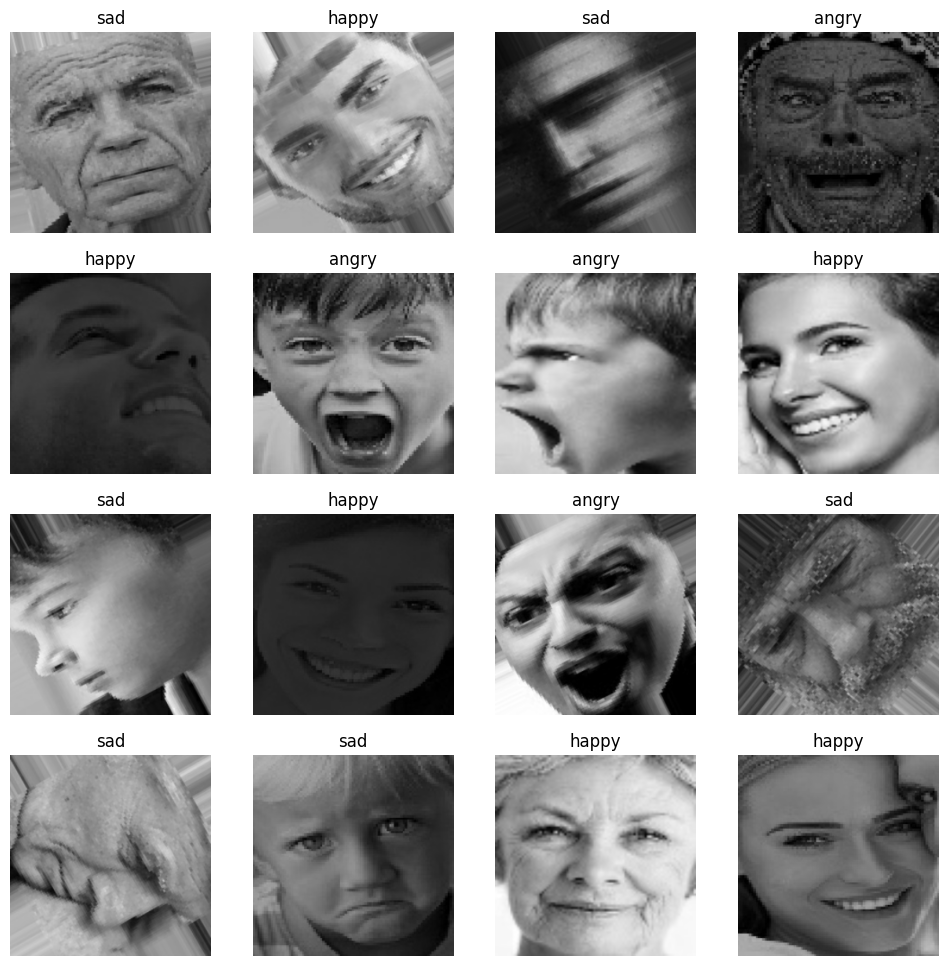

In [39]:
plt.figure(figsize = (12,12))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[int(tf.argmax(labels[i], axis=0).numpy())])
    plt.axis('off')

In [10]:
def resize_rescale(image, label):
  #print('Inside the function call')
  #tf.print('Using tf print')
  return tf.image.resize(image, (CONFIGARATION['IM_SIZE'], CONFIGARATION['IM_SIZE']))/255.0, label

resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGARATION['IM_SIZE'], CONFIGARATION['IM_SIZE']),
    Rescaling(1.0/255)
])
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1),
])
def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [40]:
training_dataset = (
    train_dataset
    #.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    )
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
    )

In [12]:
IM_SIZE = CONFIGARATION['IM_SIZE']
DROPOUT_RATE = CONFIGARATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGARATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGARATION['N_FILTERS']
KERNEL_SIZE = CONFIGARATION['KERNEL_SIZE']
POOL_SIZE = CONFIGARATION['POOL_SIZE']
N_STRIDES = CONFIGARATION['N_STRIDES']
NUM_CLASSES = CONFIGARATION['NUM_CLASSES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),
    resize_rescale_layers,

    Conv2D(filters = N_FILTERS, kernel_size = KERNEL_SIZE, strides = N_STRIDES,
           padding = 'valid', activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size = POOL_SIZE, strides = N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE),

    Conv2D(filters = N_FILTERS*2+4, kernel_size = KERNEL_SIZE, strides = N_STRIDES,
           padding = 'valid', activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size = POOL_SIZE, strides = N_STRIDES*2),

    Flatten(),

    Dense(CONFIGARATION['N_DENSE_1'], activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense(CONFIGARATION['N_DENSE_2'], activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation = 'softmax')
    ])

lenet_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       6,150,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding
    )
    self.batch_norm = BatchNormalization()

  def call(self, x):
    x = self.conv(x)
    x = self.batch_norm(x)

    return x

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides=1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = 'same')
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = 'same')

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input):
    x = self.custom_conv_1(input)
    x = self.custom_conv_2(x)

    if self.dotted:
      x_add = self.custom_conv_3(input)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding='same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()
    self.fc_3 = Dense(CONFIGARATION['NUM_CLASSES'], activation='softmax')

  def call(self, x):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x)
    x = self.conv_2_2(x)
    x = self.conv_2_3(x)

    x = self.conv_3_1(x)
    x = self.conv_3_2(x)
    x = self.conv_3_3(x)
    x = self.conv_3_4(x)

    x = self.conv_4_1(x)
    x = self.conv_4_2(x)
    x = self.conv_4_3(x)
    x = self.conv_4_4(x)
    x = self.conv_4_5(x)
    x = self.conv_4_6(x)

    x = self.conv_5_1(x)
    x = self.conv_5_2(x)
    x = self.conv_5_3(x)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
#resnet_34(tf.zeros([1,256,256,3]))
#resnet_34.summary()

### Transfer Learning with EfficientNet

In [41]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGARATION['IM_SIZE'], CONFIGARATION['IM_SIZE'], 3),
)

In [42]:
backbone.trainable = False

In [43]:
model = tf.keras.Sequential([
    Input(shape=(CONFIGARATION['IM_SIZE'], CONFIGARATION['IM_SIZE'], 3)),
    #resize_rescale_layers,
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGARATION['N_DENSE_1'], activation='relu'),
    BatchNormalization(),
    Dense(CONFIGARATION['N_DENSE_2'], activation='relu'),
    Dense(CONFIGARATION['NUM_CLASSES'], activation='softmax')
])

In [44]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

In [45]:
checkpoint_callback = ModelCheckpoint('best_model.keras',
                                      monitor='val_accuracy', verbose=1,
                                      save_best_only=True)

In [46]:
loss_function = CategoricalCrossentropy()

In [47]:
metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k=2, name='top_K_accuracy')]

In [48]:
if CONFIGARATION['MODEL_NAME'] == 'resnet_34':
  resnet_34.compile(
      optimizer = Adam(learning_rate = CONFIGARATION['LEARNING_RATE']),
      loss = loss_function,
      metrics = metrics
  )
elif CONFIGARATION['MODEL_NAME'] == 'lenet':
  lenet_model.compile(
      optimizer = Adam(learning_rate = CONFIGARATION['LEARNING_RATE']),
      loss = loss_function,
      metrics = metrics
  )
elif CONFIGARATION['MODEL_NAME'] == 'efficientnet':
  model.compile(
      optimizer = Adam(learning_rate = CONFIGARATION['LEARNING_RATE']),
      loss = loss_function,
      metrics = metrics
  )


In [49]:
history = model.fit(training_dataset,
                    validation_data=validation_dataset,
                    epochs=20, verbose=1, callbacks = [checkpoint_callback])

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.6339 - loss: 1.0222 - top_K_accuracy: 0.8666
Epoch 1: val_accuracy improved from -inf to 0.72651, saving model to best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.6349 - loss: 1.0185 - top_K_accuracy: 0.8672 - val_accuracy: 0.7265 - val_loss: 0.6826 - val_top_K_accuracy: 0.9166
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7890 - loss: 0.5238 - top_K_accuracy: 0.9433
Epoch 2: val_accuracy improved from 0.72651 to 0.74890, saving model to best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 650ms/step - accuracy: 0.7891 - loss: 0.5237 - top_K_accuracy: 0.9433 - val_accuracy: 0.7489 - val_loss: 0.6464 - val_top_K_accuracy: 0.9179
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8129 - loss: 0.4427 - top_K_accuracy: 0.9566
Epoch 3: val_accuracy improved from 0.74890 to 0.78402, saving model to best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - accuracy: 0.8131 

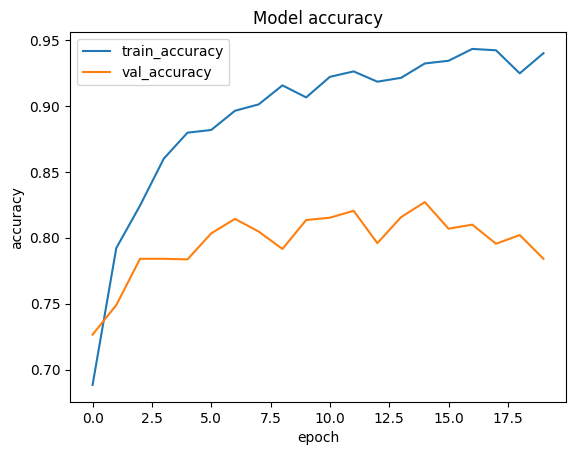

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [51]:
model.load_weights('best_model.keras')

In [52]:
validation_dataset = validation_dataset.unbatch().batch(16)
model.evaluate(validation_dataset)

143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.8315 - loss: 0.6006 - top_K_accuracy: 0.9434


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.5738537311553955, 0.8270412683486938, 0.9464442729949951]

In [53]:
predicted = []
labels = []
for im, label in validation_dataset:
  predicted.append(model.predict(im))
  labels.append(label.numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

In [54]:
print(predicted[0].shape)
print(labels[0].shape)

(16, 3)
(16, 3)


In [55]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))


[2 2 2 ... 2 1 2]
[1 2 2 ... 2 2 2]


[[323  58 134]
 [ 73 841  92]
 [109  94 554]]


Text(0.5, 58.7222222222222, 'Predicted')

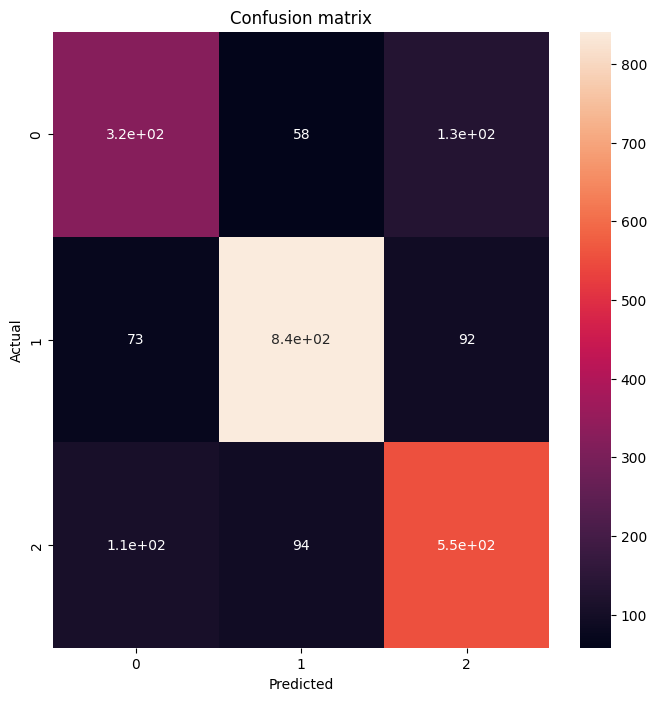

In [56]:
# as batch size for last is different, have to process it separately and concatenate
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])


cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

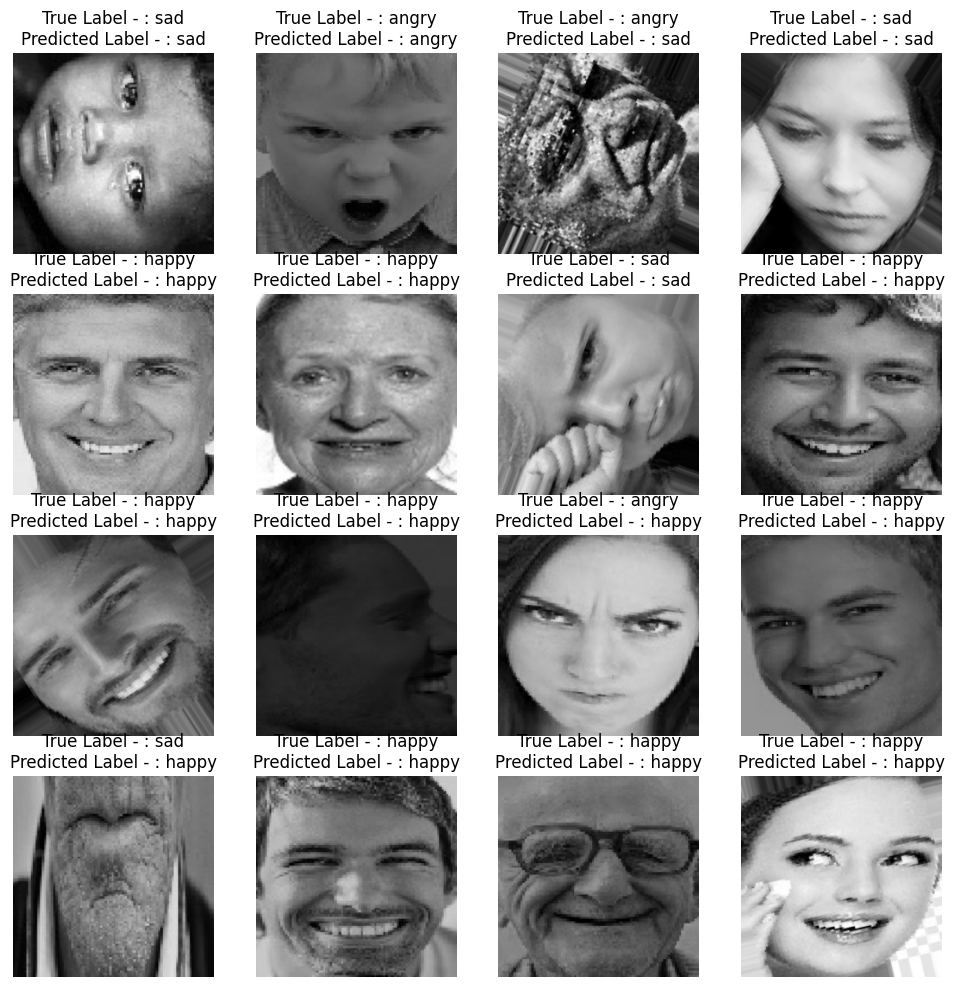

In [57]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + CLASS_NAMES[int(tf.argmax(model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")